# How do socioeconomic factors affect crime rates in Seattle?
## Chantria Im, Ellie Velez, and Nawaf Osman

In [1]:
%%capture
%%script echo skipping # Skip this code cell

# Install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install folium mapclassify

In [2]:
# Import libraries
import pandas as pd
import requests
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
# Load datasets
crime_df = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
poverty_df = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv', 
                         converters={'Census Tract': str.strip})
income_df = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')
geo_df = gpd.read_file('./data/cb_2018_53_tract_500k/cb_2018_53_tract_500k.shp')

In [4]:
def crime_clean(crime_df):
    # Remove rows with missing Longitude and Latitude values
    # The following offense types purposefully lack geodata:
    # ['KIDNAPPING/ABDUCTION', 'SEX OFFENSES', 'HUMAN TRAFFICKING', 'FAMILY OFFENSES, NONVIOLENT', 'ANIMAL CRUELTY',
    # 'HOMICIDE OFFENSES', 'PEEPING TOM', 'DRUNKENNESS', SEX OFFENSES, CONSENSUAL']
    crime_df = crime_df[(crime_df['Longitude'] != 0) & (crime_df['Latitude'] != 0)].copy()

    # Filter for only 2018 entries
    crime_df['Report DateTime'] = pd.to_datetime(crime_df['Report DateTime'], format='%m/%d/%Y %I:%M:%S %p')
    crime_df = crime_df[crime_df['Report DateTime'].dt.year == 2018]

    # Add Census Tract column
    crime_df['Census Tract'] = pd.Series(dtype='string')
    
    # Drop un-needed columns
    crime_df = crime_df.filter(['Census Tract', 'Offense Start DateTime', 'Report DateTime', 'Offense Parent Group', 
                                'Longitude', 'Latitude'])
    return crime_df
   
crime_df = crime_clean(crime_df)

In [5]:
def crime_tracts(crime_df):
    # Fill Census Tract column with corresponding census tract numbers
    i = 0
    while i < len(crime_df):
        # Make request to Census Geocoder API to get row census tract data based on row longtitude and latitude values
        payload = {'benchmark': 'Public_AR_Current', 'vintage': 'ACS2018_Current', 'x': crime_df['Longitude'].iloc[i], 
                   'y': crime_df['Latitude'].iloc[i], 'format': 'json', 'layers': 'Census Tracts'}
        try:
            r = requests.get(f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates', params=payload)
        except requests.Timeout:
            time.sleep(300)
            continue
        # Extract the census tract number from the response and store it in the Census Tract column
        crime_df['Census Tract'].iloc[i] = re.findall('\d+\.\d+|\d+', 
                                                      r.json()['result']['geographies']['Census Tracts'][0]['NAME'])[0]
        i += 1
    
    return crime_df.drop(['Longitude', 'Latitude'], axis=1)

In [6]:
%%capture
%%script echo skipping # Skip this code cell

crime_df = crime_tracts(crime_df)

# Backup dataframe to disk 
crime_df.to_csv('./data/crime.csv')

In [7]:
pd.set_option('display.max_colwidth', None)

# Cache the dataframe
# %store crime_df

# Reload the dataframe from cache rather than recomputing (5+ hours)
%store -r crime_df

# Reload the dataframe from disk backup
# crime_df = pd.read_csv('./data/crime.csv', converters={'Census Tract': str.strip}, parse_dates=['Report DateTime'])

In [8]:
def income_clean(income_df):
    # Remove rows with missing median income values
    # The following census tracts lack median income values:
    # ['53.02', '9901']
    income_df = income_df[pd.to_numeric(income_df['S1903_C03_001E'], errors='coerce').notna()]

    # Extract and set census tract numbers
    for i in range(len(income_df)):
        income_df.iat[i, income_df.columns.get_loc('NAME')] = re.findall('\d+\.\d+|\d+', income_df['NAME'].iloc[i])[0]

    # Edit column names
    income_df = income_df.rename(columns={'NAME': 'Census Tract', 'S1903_C03_001E': 'Median Income'})

    # Set median income column to numeric type
    income_df['Median Income'] = pd.to_numeric(income_df['Median Income'])
    
    # Drop un-needed columns
    income_df = income_df.filter(['Census Tract', 'Median Income'])
    return income_df

income_df = income_clean(income_df)

In [9]:
def poverty_clean(poverty_df):
    # Drop empty columns
    poverty_df = poverty_df.drop(['% of Population Under 100% Poverty Line', '% of Population Under 200% Poverty Line', 
                                  'Share Below Selected % of Poverty Level'], axis=1)

    # Group data by census tract and calculate total poverty population for levels
    poverty_by_tract = poverty_df[poverty_df['Name'] != 'Total'].groupby('Census Tract').agg(
        {'Population Under 100% Poverty Level': 'sum', 'Population Under 200% Poverty Level': 'sum'})

    # For each census tract fill designated 'Total' row with total poverty populations for levels
    poverty_df.loc[
        poverty_df['Name'] == 'Total', 
        'Population Under 100% Poverty Level'] = poverty_df.loc[
        poverty_df['Name'] == 'Total', 'Census Tract'].map(
        poverty_by_tract['Population Under 100% Poverty Level']).values
    poverty_df.loc[
        poverty_df['Name'] == 'Total', 
        'Population Under 200% Poverty Level'] = poverty_df.loc[
        poverty_df['Name'] == 'Total', 'Census Tract'].map(
        poverty_by_tract['Population Under 200% Poverty Level']).values

    # Filter for only designated 'Total' rows
    poverty_df = poverty_df[poverty_df['Name'] == 'Total']
    
    # Drop un-needed columns
    poverty_df = poverty_df.filter(['Census Tract', 'Population Under 100% Poverty Level', 'Total Population'])
    
    # Augment poverty column to percentage
    poverty_df['Population Under 100% Poverty Level'] = (
        poverty_df['Population Under 100% Poverty Level'] / poverty_df['Total Population'] * 100).round(2)
    return poverty_df

poverty_df = poverty_clean(poverty_df)

In [10]:
def geo_clean(geo_df):
    # Rename column
    geo_df = geo_df.rename(columns={'NAME': 'Census Tract'})

    # Filter for King County census tracts
    geo_df = geo_df[geo_df['COUNTYFP'] == '033']
    
    # Drop un-needed columns
    geo_df = geo_df.filter(['Census Tract', 'geometry'])
    return geo_df

geo_df = geo_clean(geo_df)

In [11]:
def cip_merge(crime_df, income_df, poverty_df):
    # Merge datasets
    # The following census tracts are missing in the crime dataset:
    # income_df[~income_df['Census Tract'].isin(merged_df['Census Tract'])]['Census Tract'].unique()
    merged_df = crime_df.merge(income_df, on='Census Tract')
    merged_df = merged_df.merge(poverty_df, on='Census Tract')
    return merged_df

merged_df = cip_merge(crime_df, income_df, poverty_df)

In [12]:
def crime_by_census(merged_df):
    # Calculate total crime offenses by census tract
    grouped_df = merged_df.groupby('Census Tract').agg({
        'Median Income': 'first',
        'Total Population': 'first',
        'Population Under 100% Poverty Level': 'first',
        'Offense Parent Group': 'count'
    })
    grouped_df = grouped_df.rename(columns={'Offense Parent Group': 'Total Offenses'})

    # Calculate crime rate per census tract
    # Crime rate is calculated by: total crime offenses / total population * 100,000
    grouped_df['Crime Rate per 100,000'] = (grouped_df['Total Offenses'] / grouped_df['Total Population']) * 100000
    grouped_df['Crime Rate per 100,000'] = grouped_df['Crime Rate per 100,000'].round()
    return grouped_df

grouped_df = crime_by_census(merged_df)

In [13]:
def offenses_by_census(merged_df):
    # Calculate crime rate per census tract by offense type
    offenses_df = merged_df.groupby(['Census Tract', 'Median Income', 'Total Population', 
                                     'Population Under 100% Poverty Level', 
                                     'Offense Parent Group']).size().reset_index(name='Offense Count')
    offenses_df['Crime Rate per 100,000'] = (offenses_df['Offense Count'] / offenses_df['Total Population']) * 100000
    offenses_df['Crime Rate per 100,000'] = offenses_df['Crime Rate per 100,000'].round()
    return offenses_df

offenses_df = offenses_by_census(merged_df)

In [14]:
def policing_by_census(merged_df):
    # Remove rows with missing offense start DateTime values
    policing_df = merged_df[merged_df['Offense Start DateTime'].notna()].copy()

    # Change column type to DateTime
    policing_df['Offense Start DateTime'] = pd.to_datetime(policing_df['Offense Start DateTime'], 
                                                           format='%m/%d/%Y %I:%M:%S %p')

    # Calculate time between offense start time and report time for each offense
    policing_df['Start-Report Time Diff'] = (policing_df['Report DateTime'] - 
                                             policing_df['Offense Start DateTime']).dt.total_seconds() / 60

    # Filter for offenses that started in 2018
    policing_df = policing_df[policing_df['Offense Start DateTime'].dt.year == 2018]

    # Calculate average policing times for each census tract
    policing_df = policing_df.groupby('Census Tract').agg({
        'Median Income': 'first',
        'Population Under 100% Poverty Level': 'first',
        'Start-Report Time Diff': 'mean'
    }).reset_index()
    
    # Round policing time to nearest minute
    policing_df['Start-Report Time Diff'] = policing_df['Start-Report Time Diff'].round()
    return policing_df

policing_df = policing_by_census(merged_df)

In [15]:
def offenses_wide(offenses_df):
    # Change dataframe from long to wide format
    offenses_wide_df = pd.pivot(
        offenses_df.filter(
            ['Census Tract', 'Offense Parent Group', 'Offense Count', 'Crime Rate per 100,000']), index='Census Tract', 
        columns='Offense Parent Group', values=['Offense Count', 'Crime Rate per 100,000'])

    # Rename columns
    offenses_wide_df.columns = offenses_wide_df.columns.get_level_values(0) + '-' + offenses_wide_df.columns.get_level_values(1)
    return offenses_wide_df

offenses_wide_df = offenses_wide(offenses_df)

In [16]:
def gop_merge(grouped_df, offenses_wide_df, policing_df):
    # Merge datasets
    data = grouped_df.merge(offenses_wide_df, on='Census Tract')
    data = data.merge(policing_df.filter(['Census Tract', 'Start-Report Time Diff']), on='Census Tract')
    data = geo_df.merge(data, on='Census Tract')

    # Filter out un-needed columns
    data = data.drop(data.columns[data.columns.str.startswith('Offense Count-')], axis=1)
    
    # Rename columns
    data = data.rename(columns={'Population Under 100% Poverty Level': 'Percent Under Poverty Level', 
                                'Start-Report Time Diff': 'Avg. Police Response Time (min)'})
    return data

data = gop_merge(grouped_df, offenses_wide_df, policing_df)

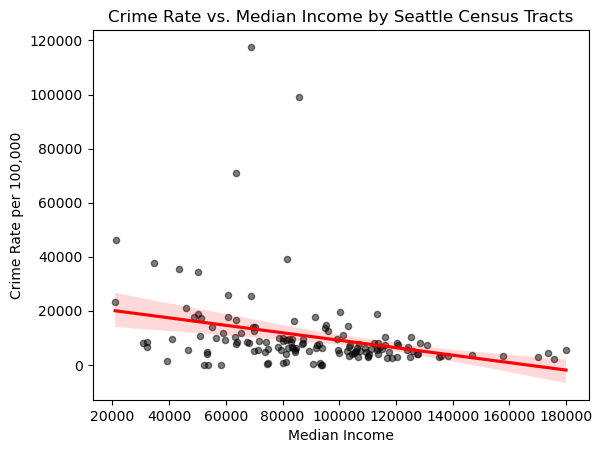

In [17]:
def crime_median_plot(grouped_df):
    # Crime rate vs median income scatter plot
    sns.regplot(x=grouped_df['Median Income'], y=grouped_df['Crime Rate per 100,000'], color='red', 
                scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Crime Rate vs. Median Income by Seattle Census Tracts')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

crime_median_plot(grouped_df)

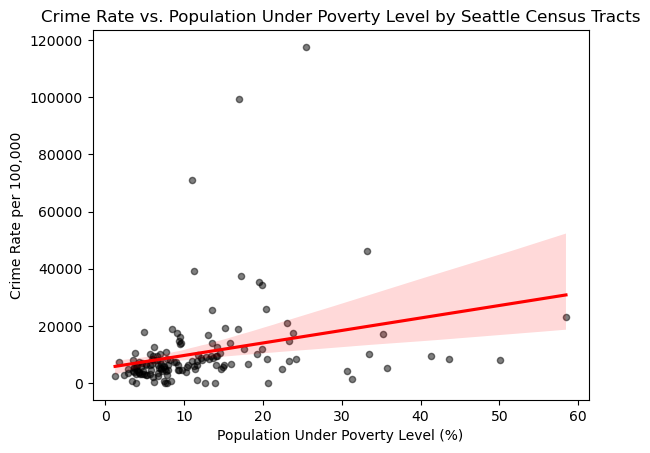

In [18]:
def crime_poverty_plot(grouped_df):
    # Crime rate vs under 100% poverty level scatter plot
    sns.regplot(x=grouped_df['Population Under 100% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], 
                color='red', scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Crime Rate vs. Population Under Poverty Level by Seattle Census Tracts')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()
    
crime_poverty_plot(grouped_df)

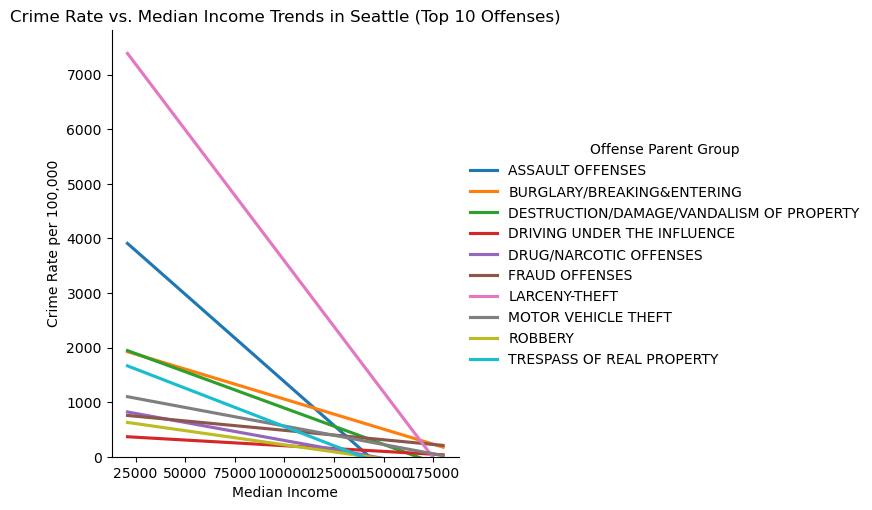

In [19]:
def offenses_income_10_plot(offenses_df):
    # Crime rate vs median income by top 10 offense types regression plot
    sns.lmplot(data=offenses_df[
        offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Median Income', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Median Income Trends in Seattle (Top 10 Offenses)')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()
    
offenses_income_10_plot(offenses_df)

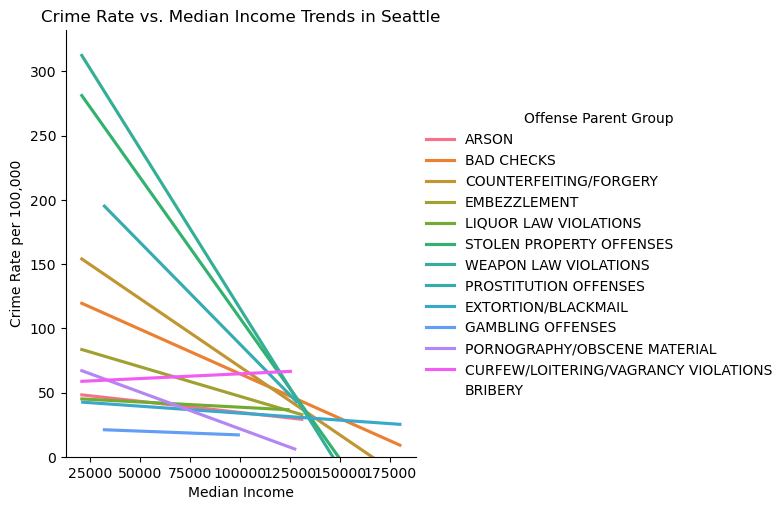

In [20]:
def offenses_income_plot(offenses_df):
    # Crime rate vs median income by offense type regression plot
    sns.lmplot(data=offenses_df[
        ~offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Median Income', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Median Income Trends in Seattle')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()
    
offenses_income_plot(offenses_df)

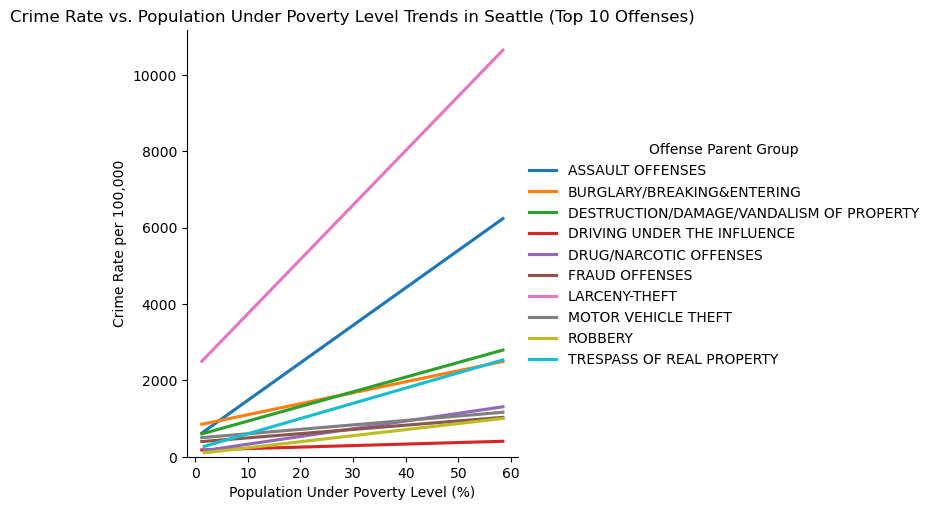

In [21]:
def offenses_poverty_10_plot(offenses_df):
    # Crime rate vs under 100% poverty level by top 10 offense types regression plot
    sns.lmplot(data=offenses_df[
        offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Population Under 100% Poverty Level', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Population Under Poverty Level Trends in Seattle (Top 10 Offenses)')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()
    
offenses_poverty_10_plot(offenses_df)

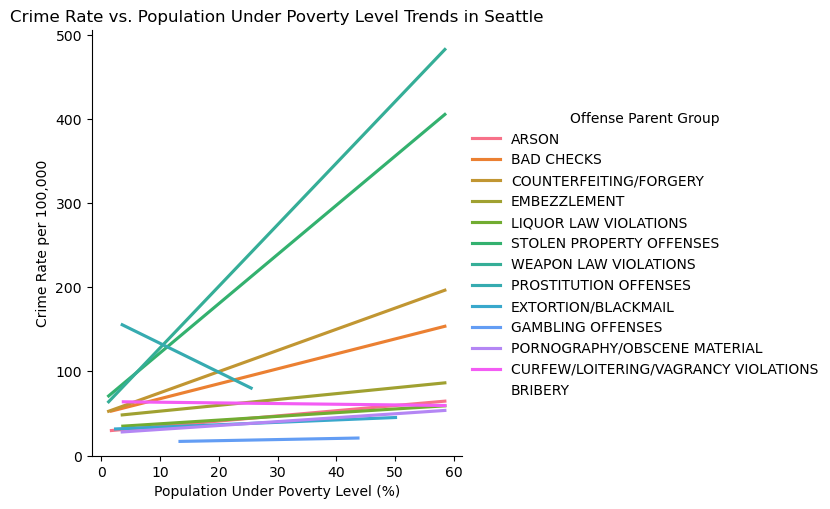

In [22]:
def offenses_poverty_plot(offenses_df):
    # Crime rate vs under 100% poverty level by offense types regression plot
    sns.lmplot(data=offenses_df[
        ~offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT',
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Population Under 100% Poverty Level', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Population Under Poverty Level Trends in Seattle')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()
    
offenses_poverty_plot(offenses_df)

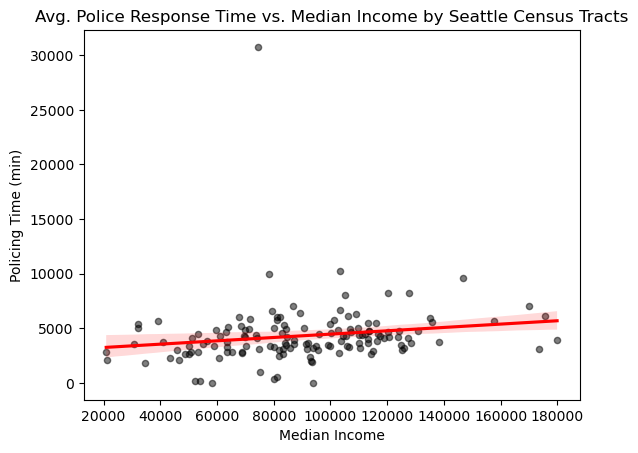

In [23]:
def policing_income_plot(policing_df):
    # Policing time from offense start time vs median income scatter plot
    sns.regplot(x=policing_df['Median Income'], y=policing_df['Start-Report Time Diff'], color='red', 
                scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Avg. Police Response Time vs. Median Income by Seattle Census Tracts')
    plt.xlabel('Median Income')
    plt.ylabel('Policing Time (min)')
    plt.show()
    
policing_income_plot(policing_df)

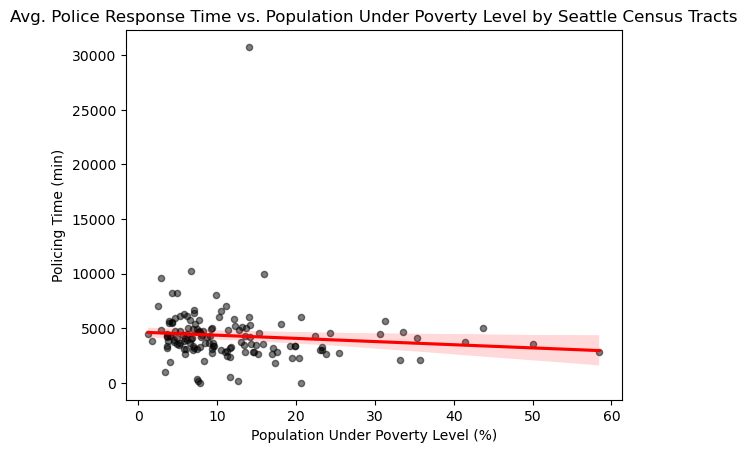

In [24]:
def policing_poverty_plot(policing_df):
    # Policing time from offense start time vs under 100% poverty level scatter plot
    sns.regplot(x=policing_df['Population Under 100% Poverty Level'], y=policing_df['Start-Report Time Diff'], 
                color='red', scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Avg. Police Response Time vs. Population Under Poverty Level by Seattle Census Tracts')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Policing Time (min)')
    plt.show()
    
policing_poverty_plot(policing_df)

In [25]:
def interactive_map(data):
    # Display interactive map
    return data.explore()
    
display(interactive_map(data))

## Testing

In [26]:
# Create crime testing dataset
crime_test = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
crime_test = crime_test[crime_test['Offense ID'].isin([
    12605873663, 7686420892, 12604929082, 7633823762, 7630358285, 7696639702, 7664183259, 7685572628, 7631819895, 
    7687620453])]

# Create income testing dataset
income_test = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')
income_test = income_test[income_test['GEO_ID'].isin([
    '1400000US53033010100', '1400000US53033006200', '1400000US53033001701', '1400000US53033007900', 
    '1400000US53033003600','1400000US53033005302', '1400000US53033001500', '1400000US53033002800', 
    '1400000US53033007401', '1400000US53033000100'])]

# Create poverty testing dataset
poverty_test = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv')
poverty_test = poverty_test[poverty_test['Census Tract'].isin([
    '1', '15', '17.01', '28', '36', '62', '74.01', '79', '101', '53.02'])]

# Create geo testing dataset
geo_test = gpd.read_file('./data/cb_2018_53_tract_500k/cb_2018_53_tract_500k.shp')
geo_test = geo_test[geo_test['NAME'].isin([
    '1', '15', '17.01', '28', '36', '62', '74.01', '79', '101', '53.02'])]

In [27]:
crime_test = crime_clean(crime_test)

assert len(crime_test) == 7
assert list(crime_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                    'Offense Parent Group', 'Longitude', 'Latitude']
assert len(crime_test[(crime_test['Longitude'] == 0) | (crime_test['Latitude'] == 0)]) == 0
assert len(crime_test['Report DateTime'].dt.year == 2018) == 7

In [28]:
crime_test = crime_tracts(crime_test)

assert len(crime_test) == 7
assert list(crime_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                    'Offense Parent Group']
assert list(crime_test['Census Tract']) == ['101', '75', '62', '17.01', '79', '79', '53.02']

In [29]:
income_test = income_clean(income_test)

assert len(income_test) == 9
assert list(income_test.columns) == ['Census Tract', 'Median Income']
assert list(income_test['Census Tract']) == ['1', '15', '17.01', '28', '36', '62', '74.01', '79', '101']
assert str(income_test.dtypes['Median Income']) == 'int64'

In [30]:
poverty_test = poverty_clean(poverty_test)

assert len(poverty_test) == 10
assert list(poverty_test.columns) == ['Census Tract', 'Population Under 100% Poverty Level', 'Total Population']
assert list(poverty_test['Population Under 100% Poverty Level']) == [14.24, 5.31, 5.24, 19.23, 14.53, 68.79, 7.42, 
                                                                     13.54, 4.5, 14.05]

In [31]:
geo_test = geo_clean(geo_test)

assert len(geo_test) == 10
assert list(geo_test.columns) == ['Census Tract', 'geometry']

In [32]:
merged_test = cip_merge(crime_test, income_test, poverty_test)

assert len(merged_test) == 5
assert list(merged_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                     'Offense Parent Group', 'Median Income', 'Population Under 100% Poverty Level', 
                                     'Total Population']

In [33]:
grouped_test = crime_by_census(merged_test)

assert len(grouped_test) == 4
assert list(grouped_test.reset_index().columns) == ['Census Tract', 'Median Income', 'Total Population', 
                                      'Population Under 100% Poverty Level', 'Total Offenses', 
                                      'Crime Rate per 100,000']
grouped_test['Crime Rate per 100,000']
assert list(grouped_test['Crime Rate per 100,000']) == [11.0, 25.0, 22.0, 32.0]

In [34]:
offenses_test = offenses_by_census(merged_test)

assert len(offenses_test) == 5
assert list(offenses_test.columns) == ['Census Tract', 'Median Income', 'Total Population', 
                                       'Population Under 100% Poverty Level', 'Offense Parent Group', 'Offense Count', 
                                       'Crime Rate per 100,000']
assert list(offenses_test['Crime Rate per 100,000']) == [11.0, 25.0, 22.0, 16.0, 16.0]

In [35]:
policing_test = policing_by_census(merged_test)

assert len(policing_test) == 4
assert list(policing_test.columns) == ['Census Tract', 'Median Income', 'Population Under 100% Poverty Level', 
                                       'Start-Report Time Diff']
assert list(policing_test['Start-Report Time Diff']) == [254.0, 0.0, 429.0, 493.0]

In [36]:
offenses_wide_test = offenses_wide(offenses_test)

assert len(offenses_wide_test) == 4
assert list(
    offenses_wide_test.reset_index().columns) == ['Census Tract', 
                                                  'Offense Count-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                                  'Offense Count-LARCENY-THEFT', 
                                                  'Crime Rate per 100,000-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                                  'Crime Rate per 100,000-LARCENY-THEFT']

In [40]:
data_test = gop_merge(grouped_test, offenses_wide_test, policing_test)

assert len(data_test) == 4
assert list(data_test.columns) == ['Census Tract', 'geometry', 'Median Income', 'Total Population', 
                                   'Percent Under Poverty Level', 'Total Offenses', 'Crime Rate per 100,000', 
                                   'Crime Rate per 100,000-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                   'Crime Rate per 100,000-LARCENY-THEFT', 'Avg. Police Response Time (min)']